<a href="https://colab.research.google.com/github/aswathyachuzz/Segmentation/blob/main/segmentation_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




ROBOTS.OX






In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import os
from pathlib import Path

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-05-13 10:24:24--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-05-13 10:24:24--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-05-13 10:24:25--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-str

In [ ]:
img_width = 256
img_height = 256

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode=None,
    color_mode='rgb',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    'images',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode=None,
    color_mode='rgb',
    subset='validation',
    shuffle=False
)

train_masks = []
for path, subdirs, files in os.walk('annotations/trimaps'):
    for filename in files:
        train_masks.append(os.path.join(path, filename))

val_masks = []
for path, subdirs, files in os.walk('annotations/trimaps'):
    for filename in files:
        val_masks.append(os.path.join(path, filename))

train_masks_generator = train_datagen.flow_from_directory(
    'annotations',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    subset='training',
    shuffle=True,
    seed=42
)

val_masks_generator = val_datagen.flow_from_directory(
    'annotations',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    subset='validation',
    shuffle=False
)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 14780 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [ ]:
def build_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
   


oxford


In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

In [ ]:
# Load the dataset using appropriate libraries or functions
# For example, using the TensorFlow Datasets library:
import tensorflow_datasets as tfds

dataset_name = 'oxford_iiit_pet'
dataset, info = tfds.load(dataset_name, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXC6NG6/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXC6NG6/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
# Extract the training and testing data from the loaded dataset
train_data = dataset['train']
test_data = dataset['test']

# Perform any necessary preprocessing steps such as resizing, normalization, etc.
# For example, resizing the images to a specific size:
IMG_HEIGHT = 256
IMG_WIDTH = 256

def preprocess_image(image, mask):
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    return image, mask

train_data = train_data.map(lambda x: preprocess_image(x['image'], x['segmentation_mask']))
test_data = test_data.map(lambda x: preprocess_image(x['image'], x['segmentation_mask']))

# Batch and shuffle the training and testing data
BATCH_SIZE = 32
train_data = train_data.batch(BATCH_SIZE).shuffle(1000)
test_data = test_data.batch(BATCH_SIZE)


In [ ]:
def unet_model():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bridge
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up5 = UpSampling2
    plt

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

def unet(input_shape):
    inputs = Input(shape=input_shape)

    # downsample path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # bottom layer
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # upsample path
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))

In [ ]:
# Download and extract the dataset
data_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
mask_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
data_dir = tf.keras.utils.get_file('images', origin=data_url, untar=True)
mask_dir = tf.keras.utils.get_file('annotations', origin=mask_url, untar=True)

In [ ]:
# Define constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32

print()

In [ ]:
# Define input pipeline
image_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
mask_data_gen = tf.keras.preprocessing.image.ImageDataGenerator()
train_data = tf.data.Dataset.from_generator(
    lambda: image_data_gen.flow_from_directory(data_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE),
    output_types=(tf.float32, tf.float32),
    output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3], [BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3])
)
train_masks = tf.data.Dataset.from_generator(
    lambda: mask_data_gen.flow_from_directory(mask_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, color_mode='grayscale'),
    output_types=(tf.float32, tf.float32),
    output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 1], [BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 1])
)
train_data = tf.data.Dataset.zip((train_data, train_masks))

In [ ]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(1, 1, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')


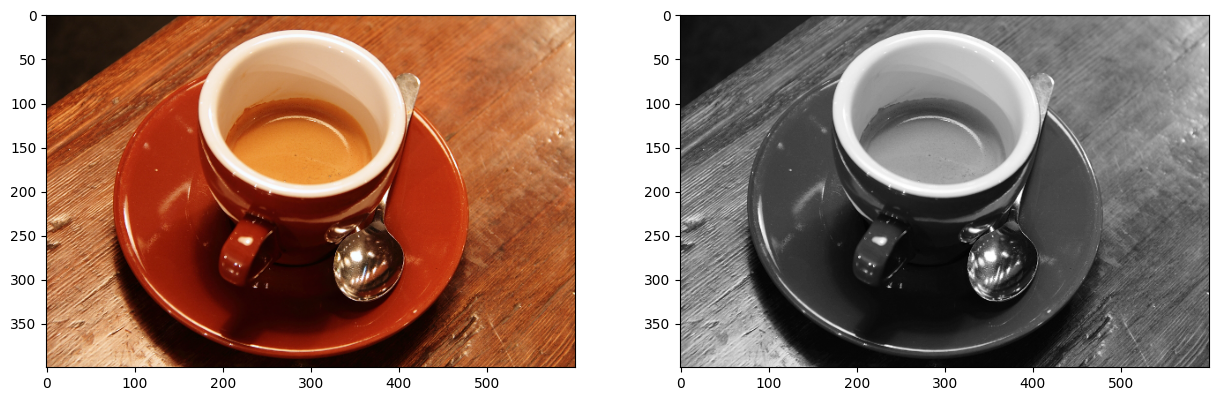

In [ ]:
# Importing Necessary Libraries
from skimage import data
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
 
# Setting the plot size to 15,15
plt.figure(figsize=(15, 15))
 
# Sample Image of scikit-image package
coffee = data.coffee()
plt.subplot(1, 2, 1)
 
# Displaying the sample image
plt.imshow(coffee)
 
# Converting RGB image to Monochrome
gray_coffee = rgb2gray(coffee)
plt.subplot(1, 2, 2)
 
# Displaying the sample image - Monochrome
# Format
plt.imshow(gray_coffee, cmap="gray")

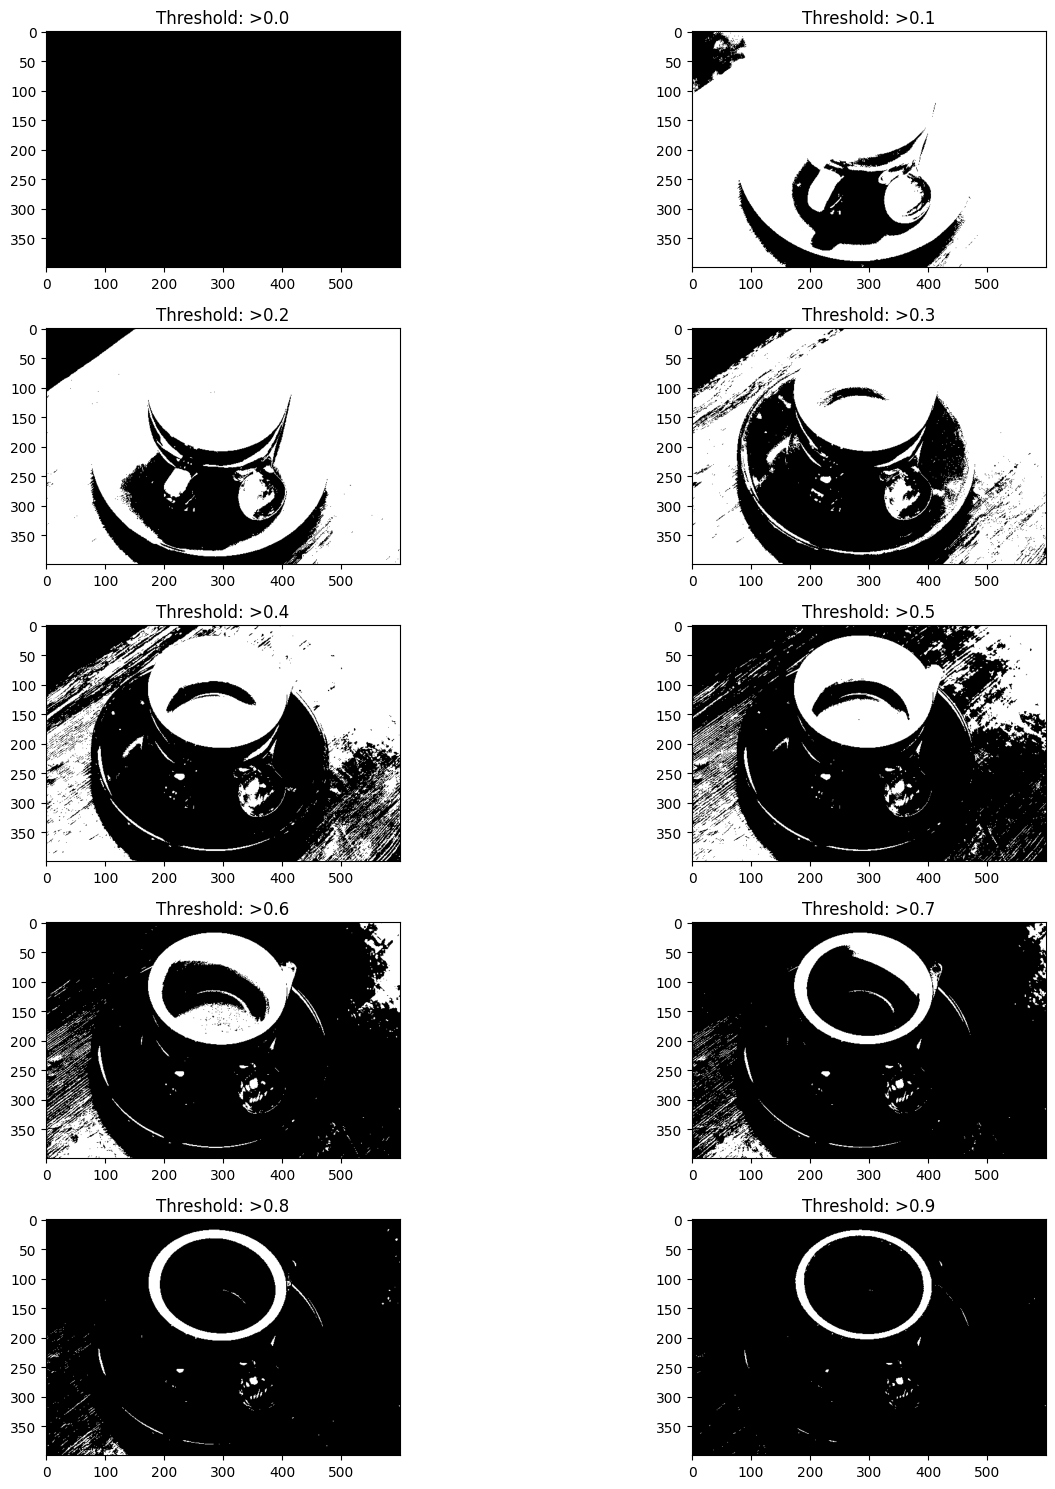

In [ ]:
# Importing Necessary Libraries
# Displaying the sample image - Monochrome Format
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
 
# Sample Image of scikit-image package
coffee = data.coffee()
gray_coffee = rgb2gray(coffee)
 
# Setting the plot size to 15,15
plt.figure(figsize=(15, 15))
 
for i in range(10):
   
  # Iterating different thresholds
  binarized_gray = (gray_coffee > i*0.1)*1
  plt.subplot(5,2,i+1)
   
  # Rounding of the threshold
  # value to 1 decimal point
  plt.title("Threshold: >"+str(round(i*0.1,1)))
   
  # Displaying the binarized image
  # of various thresholds
  plt.imshow(binarized_gray, cmap = 'gray')
   
plt.tight_layout()